# Chemotherapeutical Agents Dataset: Data Analysis

This notebook provides a first look at the Chemotherapeutical Agents Dataset, "chemo dataset", with some data analysis to grab a better view of the data.

In [1]:
# Data handling
import pandas as pd
import numpy as np

#utility functions : prepare the data 
from model_fp_selection.lib.utils import prepare_df_morgan, prepare_df_rdkit, swap_identical_ligands
from model_fp_selection.lib.utils import drop_duplicates, average_duplicates, calc_desc

#utility functions : results 
from model_fp_selection.lib.utils import obtain_metrics, plot_cv_results

# Plotting
import matplotlib.pyplot as plt
import seaborn as sns
sns.set_style("white")

# Properties of molecules
from rdkit import Chem
from rdkit.Chem import AllChem
from rdkit.Chem.Draw import IPythonConsole #RDKit drawing 
from rdkit.Chem import rdDepictor # A few settings to improve the quality of structures
IPythonConsole.ipython_useSVG = True
rdDepictor.SetPreferCoordGen(True)
import mols2grid #The mols2grid library provides a convenient way of displaying molecules in a grid


# Data Preprocessing

We import the dataset. We will create a column containing the set of the three ligand's SMILES. A set is not ordered, this will allow us to compare complexes no matter the order of entry of the ligands. We will first drop metal complexes with less than 3 ligands, and calculate the rdkit and the ECFP4 fingerprint of each ligand.

Since the order of Ligands has not chemical significance, we have to create a set. But a set is not hashable, so e.g. the 'drop_duplicate' method of pandas dataframes doesn't work. We have to freeze the set to make it hashable.

In [2]:
df_metal_complexes = pd.read_csv("ruthenium_complexes_dataset.csv", dtype={'L1': str, 'L2': str, 'L3': str})

In [3]:
#metals = prepare_df_morgan(metals, 2, 512)
df_metal_complexes = prepare_df_rdkit(df_metal_complexes)

# Different Compounds and Ligands Available

We will count the number of compounds available, and how many display each information.

The functions **drop_duplicates** and **average_duplicates** are to be called on the column 'Ligands_Dict' to filter any duplicate complexe. 

In [4]:
df_unique_complexes = df_metal_complexes.copy()
drop_duplicates(df_unique_complexes, 'Ligands_Dict')

print(f'The number of unique complexes currently in the dataset: dropping: {len(df_unique_complexes)} average :{len(df_unique_complexes)} ')

718
The number of unique complexes currently in the dataset: dropping: 718 average :718 


Now, let's analyze the prevalence of different ligands. For each ligand, we will count in how many complexes it appears. 

In [5]:
all_ligands = pd.concat([df_metal_complexes['L1'], df_metal_complexes['L2'], df_metal_complexes['L3']])
ligands = pd.DataFrame(all_ligands.unique(), columns=['SMILES'])

The **ligands** list contains the list of all the different possible ligands SMILES, with no redundancy. As several compounds only had 2 ligands, we have to eliminate the NaN values corresponding to the L3 string entries of such compounds.

In [6]:
ligands.dropna(subset=['SMILES'], inplace=True)
print(f'The number of unique ligands currently in the dataset: {len(ligands)}')

The number of unique ligands currently in the dataset: 422


**The number of rows is the number of different ligands** used in total in our complexes. Let's now see the prevalence of individual ligands.

In [7]:
ligands['occurences'] = 0 #we create a numerical column to count the occurences of each ligand.
ligand_occurence_dict = dict(zip(ligands['SMILES'], ligands['occurences']))

In [8]:
for l1 in df_unique_complexes['L1']:
    ligand_occurence_dict[l1] += 1
for l2 in df_unique_complexes['L2']:
    ligand_occurence_dict[l2] += 1
for l3 in df_unique_complexes['L3']:
    if pd.notna(l3): 
        ligand_occurence_dict[l3] += 1

Let's now visualize the ligands, in order of prevalence in our complexes. We will make use of RDKit's mols2grid function to this end.

In [9]:
sorted_ligands_dict = sorted(ligand_occurence_dict.items(), key=lambda x: x[1], reverse=True)

mol_grid_dict = dict()
mol_grid_dict['SMILES'] = [x[0] for x in sorted_ligands_dict]
mol_grid_dict['occurences'] = [x[1] for x in sorted_ligands_dict]
mol_grid_dict['molecules'] = [Chem.MolFromSmiles(x[0]) for x in sorted_ligands_dict]

mols2grid.display(mol_grid_dict, subset =["img","occurences"], substruct_highlight=True)

Number of different papers in the dataset : 

In [10]:
df_unique_papers = df_metal_complexes.copy()
df_unique_papers.drop_duplicates(subset=['DOI'], keep='first', inplace=True)

print(f'The number of unique papers currently in the dataset: {len(df_unique_papers)}')

The number of unique papers currently in the dataset: 233


# Analyze distributions

We are going to start by looking at the IC50 distribution of our entries. By **playing with the parameters p and n**, we can visualize the distribution in more or less detail.

In [70]:
def generate_bar_plot(df, title, xlabel, ylabel, num_columns, figsize=(10,6), break_axis=False):
    fig, ax = plt.subplots(figsize=figsize)
    df.plot(kind='bar', ax=ax, color=sns.color_palette('flare', num_columns))
    plt.title(title)
    plt.xticks(fontsize=12, color='k', fontweight='light')
    plt.yticks(fontsize=12, color='k', fontweight='light')
    plt.xlabel(xlabel, fontsize=14)
    plt.ylabel(ylabel, fontsize=14)
    plt.xticks(rotation=45)

    if break_axis:
        ax.axvline(
        x=split_idx - 0.5,
        linestyle=':',
        linewidth=2,
        color='black'
        )

    plt.savefig(f'{title}.png', dpi=300, bbox_inches="tight")    
    plt.show()

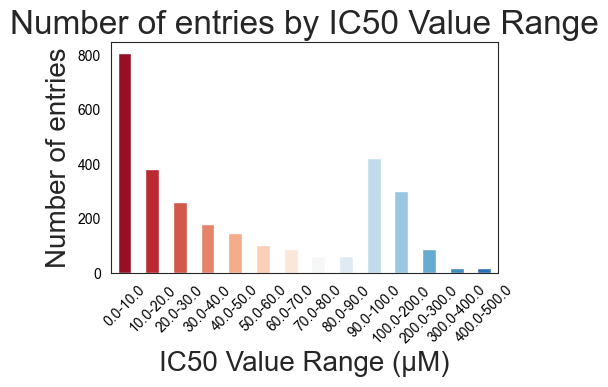

In [8]:
n = 10  # Number of subsets for the range [0, 100]
p = 4  # Number of subsets for the range [100, 500]

bin_edges_1 = np.linspace(0, 100, n + 1)
bin_edges_2 = np.linspace(100, 500, p + 1)
bin_edges = np.concatenate((bin_edges_1, bin_edges_2[1:]))

# Create bins and labels
bins = list(bin_edges)
labels = [f'{bins[i]}-{bins[i+1]}' for i in range(len(bins)-1)]

# Apply binning and count the number of compounds in each bin
plot_metals = df_metal_complexes.copy()
plot_metals['Y_bins'] = pd.cut(plot_metals['IC50'], bins=bin_edges, labels=labels, include_lowest=True)
counts = plot_metals['Y_bins'].value_counts().sort_index()

# Plot the bar plot
generate_bar_plot(counts, 'Number of entries by IC50 Value Range', 'IC50 Value Range (μM)', 
                  'Number of entries', len(bin_edges))

We now now consider the cell line distribution.

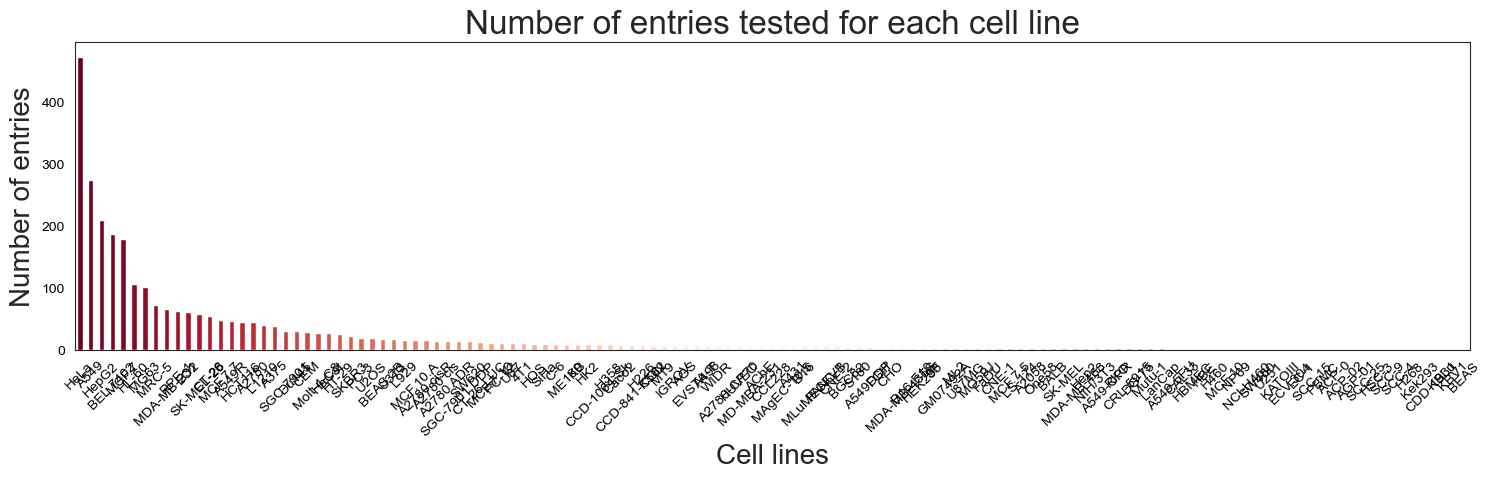

In [13]:
value_counts = df_metal_complexes['Cells'].value_counts()
cells = value_counts[value_counts >= 1]

# Plot the bar plot
generate_bar_plot(cells, 'Number of entries tested for each cell line', 'Cell lines', 'Number of entries', len(value_counts), 
                  (18, 4))

We now consider the incubation time distribution.

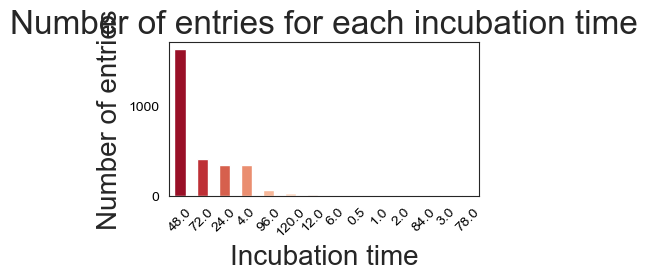

In [14]:
value_counts = df_metal_complexes['IncubationTime'].value_counts()
incubation_times = value_counts[value_counts >= 1]

generate_bar_plot(incubation_times, 'Number of entries for each incubation time', 'Incubation time', 'Number of entries', len(value_counts), 
                  (4, 2))

And finally, we consider the localization distribution.

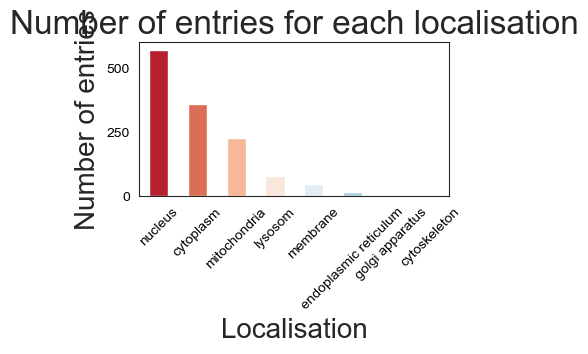

In [15]:
value_counts = df_metal_complexes['Localisation'].value_counts()
localisations = value_counts[value_counts >= 1]

generate_bar_plot(localisations, 'Number of entries for each localisation', 'Localisation', 'Number of entries', len(value_counts), 
                  (4, 2))

# Analysis of the parameter impact on the IC50 values

In [16]:
def generate_box_plot(title, df, x_column, y_column, xlabel, ylabel, fontsize=80, figsize=(80,30)):
    plt.figure(figsize=figsize)
    sns.boxplot(x=x_column, y=y_column, data=df, palette='flare')
    plt.title(title, fontsize=60)
    plt.xlabel(xlabel, fontsize=fontsize)
    plt.ylabel(ylabel, fontsize=fontsize)
    plt.xticks([]) 
    plt.yticks(fontsize=fontsize)
    plt.show()

We start with the influence of the cell line.

In [17]:
df_cell_line_analysis = df_metal_complexes.copy()

First, we are going to **only keep compound that have been tested on 2 different cell lines or more.**

In [18]:
# To have a hashable object that can be run by "groupby" function, we have to modify the 'complex_representation' column
df_cell_line_analysis['Fingerprint'] = df_cell_line_analysis['Fingerprint'].apply(lambda x: ' '.join(str(x)))

# We count the number of unique values in the 'Cells' column for each 'complex_representation'.
counts = df_cell_line_analysis.groupby('Fingerprint')['Cells'].nunique()

# We only keep the rows where the 'complex_representation' column has more than one unique value in the 'Cells' column.
cell_line_analysis = df_cell_line_analysis[df_cell_line_analysis['Fingerprint'].isin(counts[counts > 1].index)]

To filter out the potentiall confounding factors 'Incubation Time' and 'Localization', we focus on their most common values.

C:\Users\bparm\AppData\Local\Temp\ipykernel_10068\197121378.py:3: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.boxplot(x=x_column, y=y_column, data=df, palette='flare')


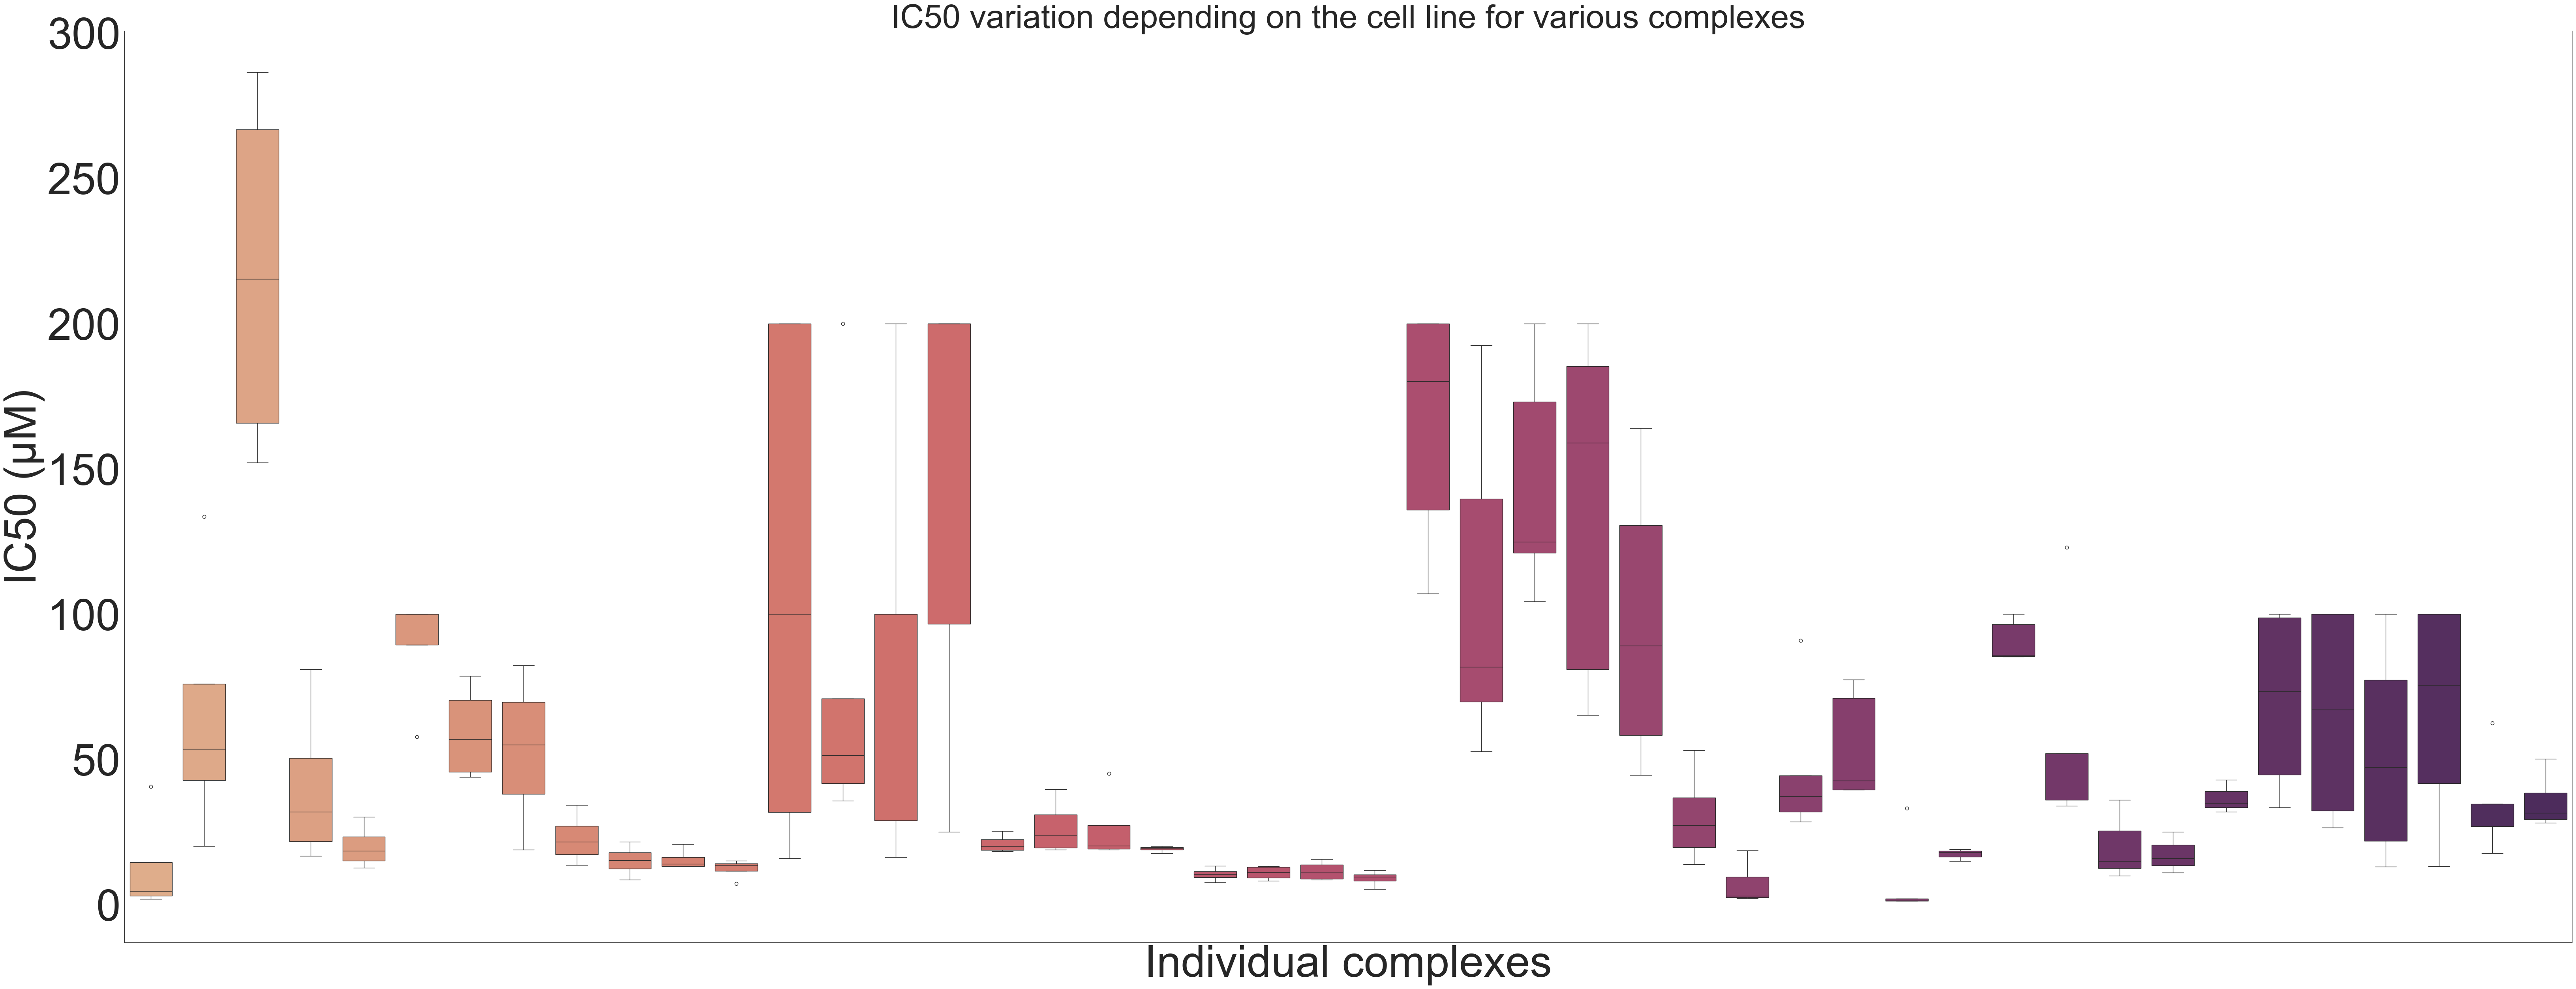

In [19]:
cell_line_analysis_48 = cell_line_analysis[cell_line_analysis['IncubationTime'] == 48]
cell_line_analysis_48c = cell_line_analysis_48[cell_line_analysis_48['Localisation'] == 'cytoplasm']

generate_box_plot("IC50 variation depending on the cell line for various complexes", cell_line_analysis_48c, 
                  "Fingerprint", "IC50", "Individual complexes", "IC50 (μM)")

C:\Users\bparm\AppData\Local\Temp\ipykernel_23544\1774195937.py:3: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.boxplot(x=x_column, y=y_column, data=df, palette='flare')


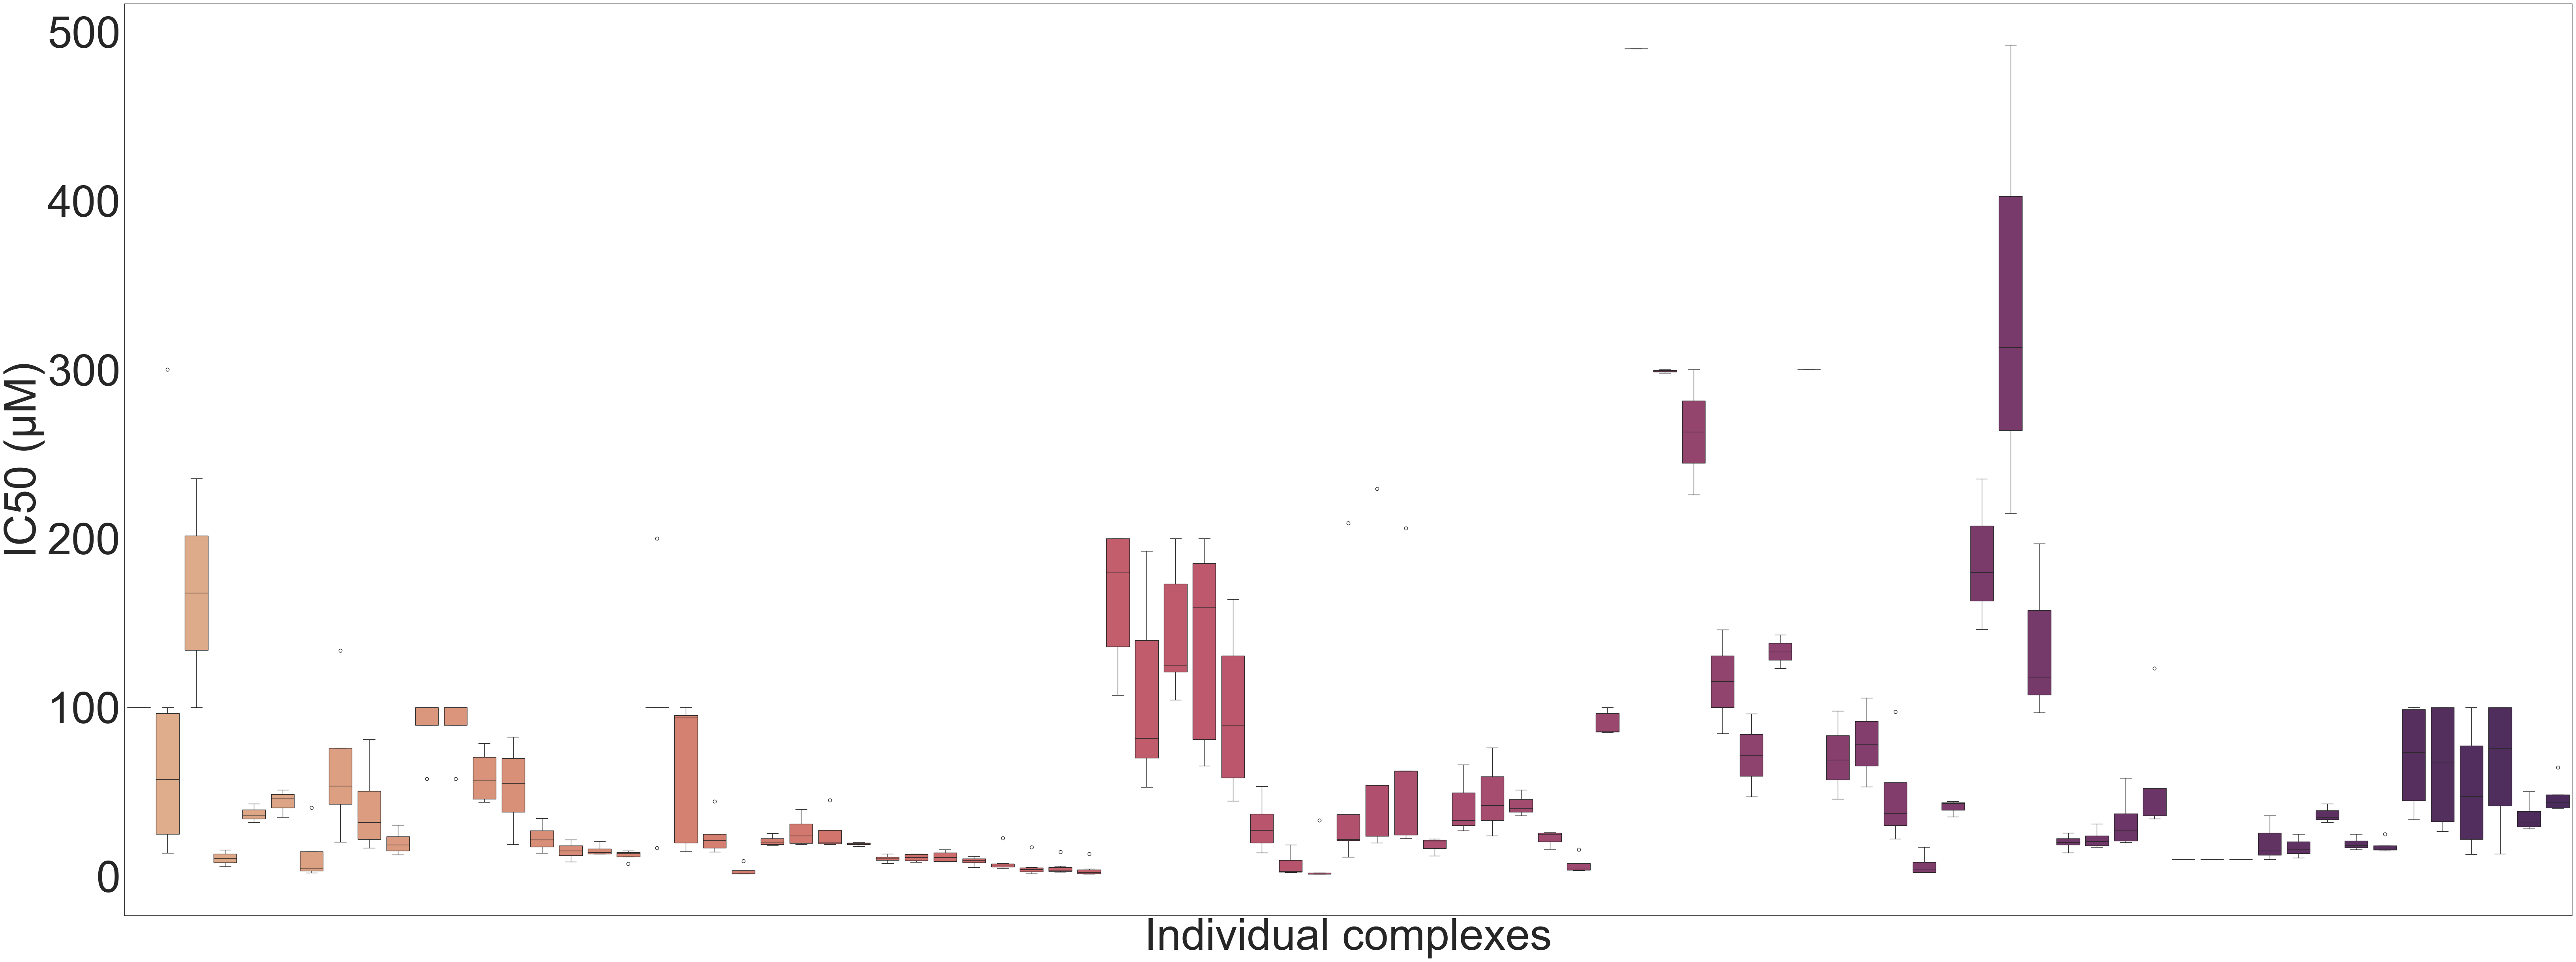

In [41]:
cell_line_analysis_48n = cell_line_analysis_48[cell_line_analysis_48['Localisation'] == 'nucleus']

generate_box_plot("IC50 variation depending on the cell line for various complexes", cell_line_analysis_48n, 
                  "Fingerprint", "IC50", "Individual complexes", "IC50 (μM)")

C:\Users\bparm\AppData\Local\Temp\ipykernel_23544\1774195937.py:3: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.boxplot(x=x_column, y=y_column, data=df, palette='flare')


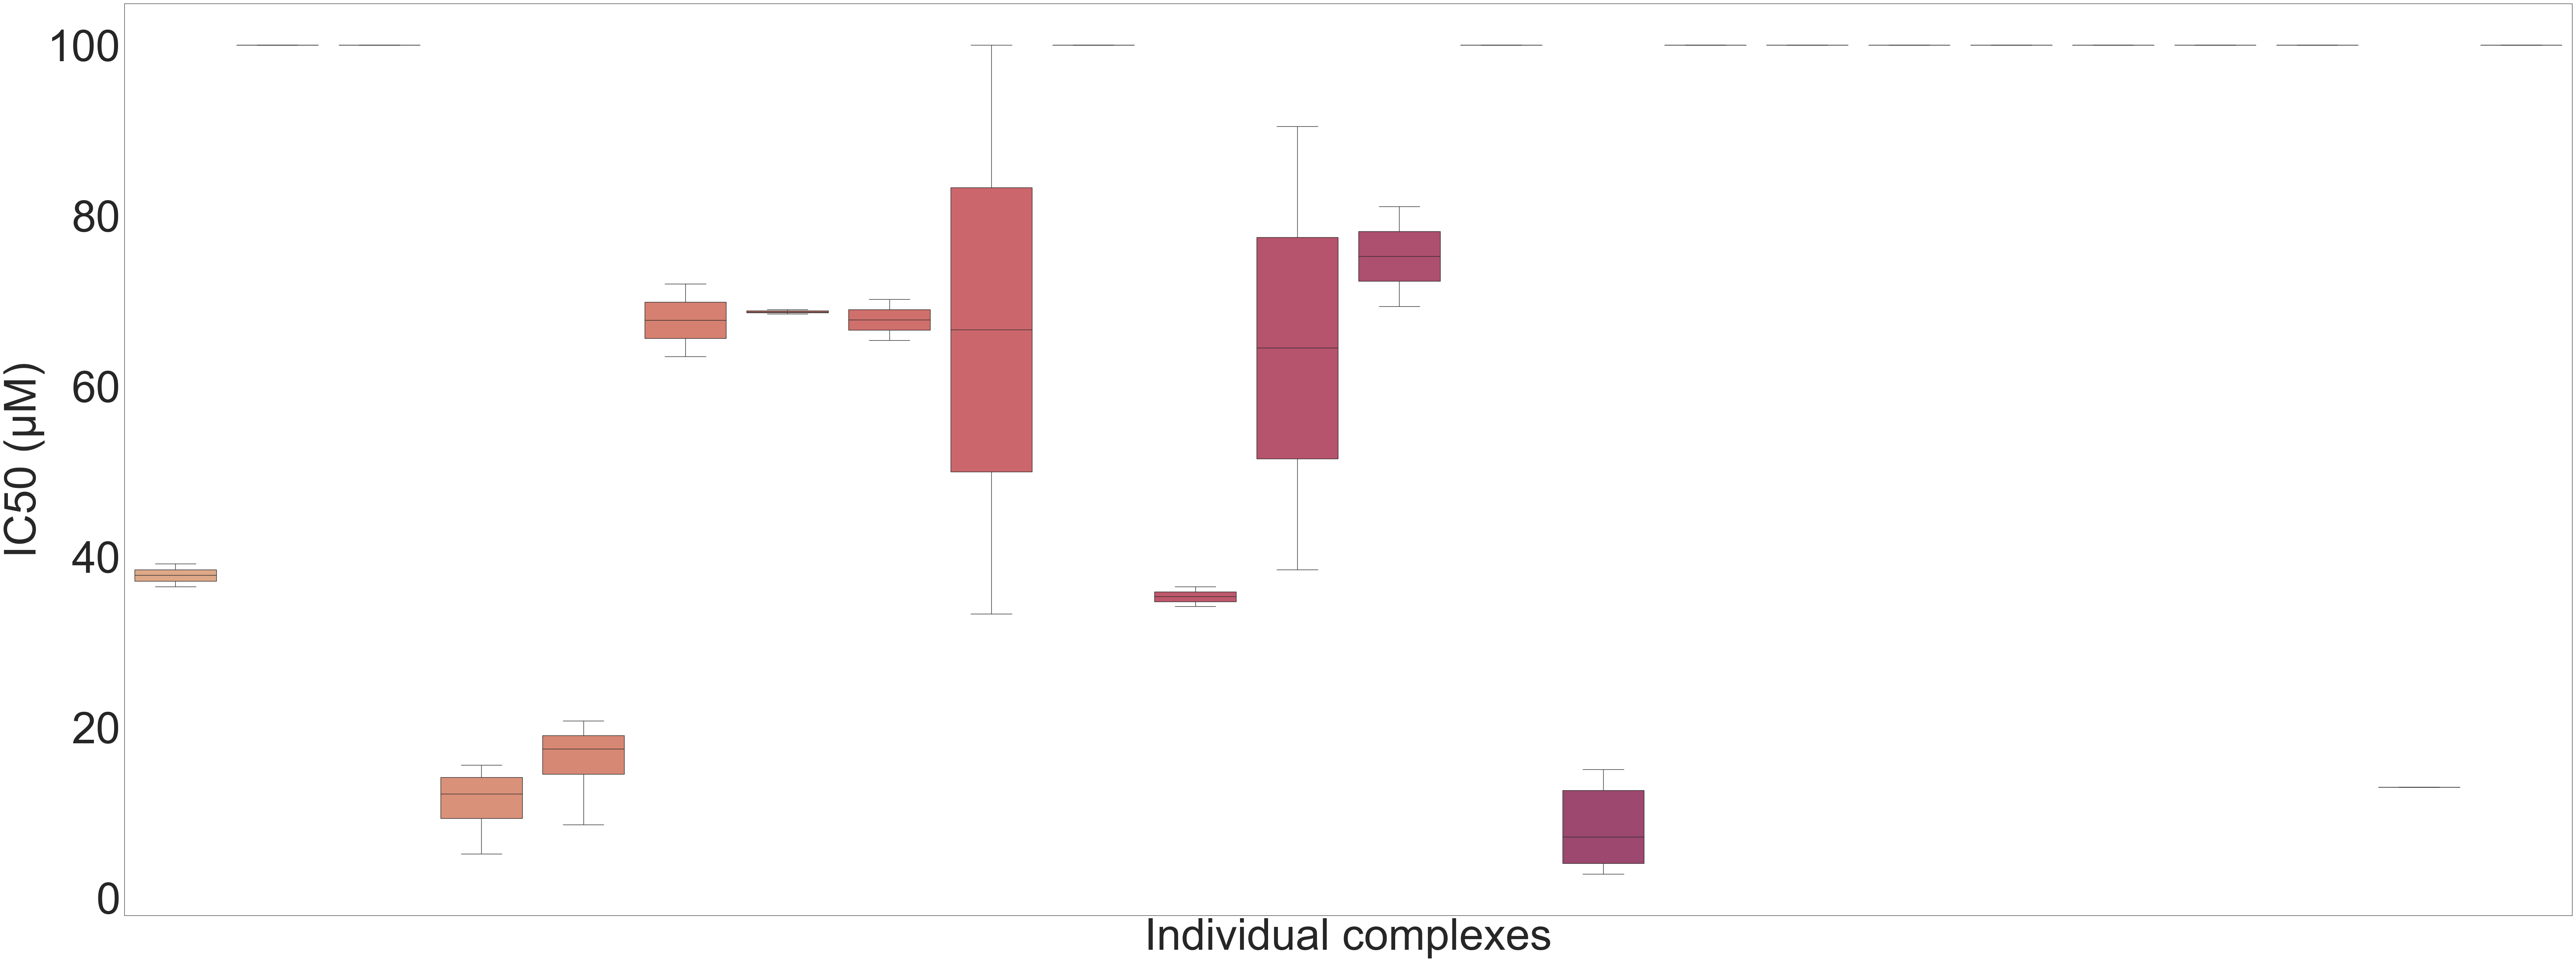

In [42]:
cell_line_analysis_4 = cell_line_analysis[cell_line_analysis['IncubationTime'] == 4]
cell_line_analysis_4c = cell_line_analysis_4[cell_line_analysis_4['Localisation'] == 'cytoplasm']

generate_box_plot("IC50 variation depending on the cell line for various complexes", cell_line_analysis_4c, 
                  "Fingerprint", "IC50", "Individual complexes", "IC50 (μM)")

C:\Users\bparm\AppData\Local\Temp\ipykernel_23544\1774195937.py:3: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.boxplot(x=x_column, y=y_column, data=df, palette='flare')


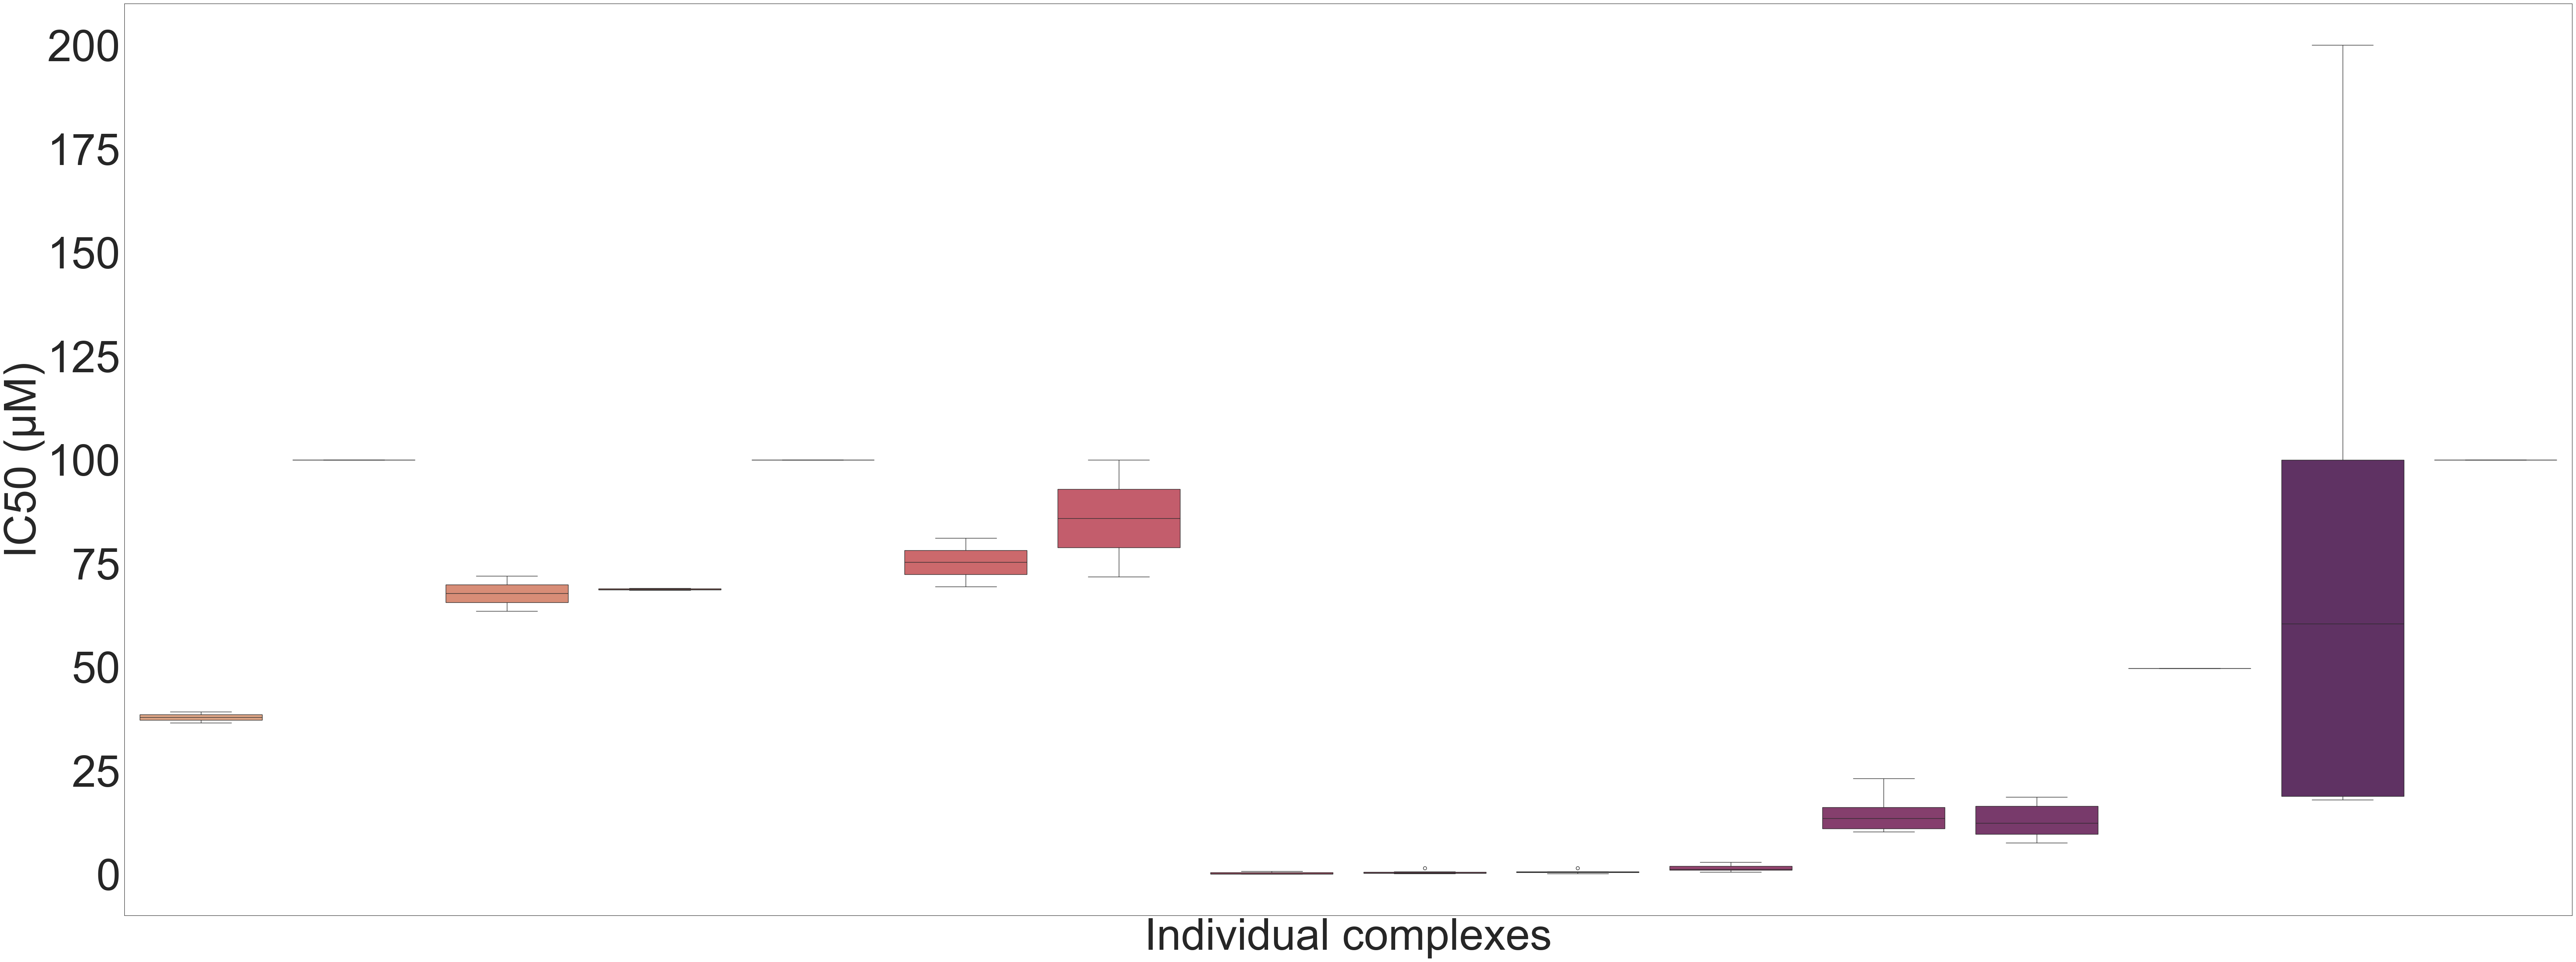

In [43]:
cell_line_analysis_4n = cell_line_analysis_4[cell_line_analysis_4['Localisation'] == 'nucleus']

generate_box_plot("IC50 variation depending on the cell line for various complexes", cell_line_analysis_4n, 
                  "Fingerprint", "IC50", "Individual complexes", "IC50 (μM)")

Clearly, the cell line plays a role in the IC50 values!

Next, we consider the influence of the incubation time.

In [44]:
df_incubation_analysis = df_metal_complexes.copy()

# To have a hashable object that can be run by "groupby" function, we have to modify the 'complex_representation' column
df_incubation_analysis['Fingerprint'] = df_incubation_analysis['Fingerprint'].apply(lambda x: ' '.join(str(x)))

# We only keep the rows where the 'complex_representation' + 'Cells' tuple has more than one unique value in the 'IncubationTime' column.
df_incubation_analysis = df_incubation_analysis.groupby(['Fingerprint', 'Cells']).filter(lambda x: x['IncubationTime'].nunique() > 1)

In [45]:
number_of_unique_values = df_incubation_analysis['Fingerprint'].nunique()
print("Unique values in 'Fingerprint' column:", number_of_unique_values)

Unique values in 'Fingerprint' column: 59


We are then going to display the different IC50 values obtained for different incubation times for each *compound + cell line* pair, to reveal the influence of incubation time in isolation.

In [46]:
# Combine columns 'complex_representation' and 'Cells' into tuples, so that we have a compound tested on a specific cell line
df_incubation_analysis['R+C'] = df_incubation_analysis.apply(lambda x: ' '.join(str(x['Fingerprint'])) + x['Cells'], axis=1)

C:\Users\bparm\AppData\Local\Temp\ipykernel_23544\1774195937.py:3: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.boxplot(x=x_column, y=y_column, data=df, palette='flare')


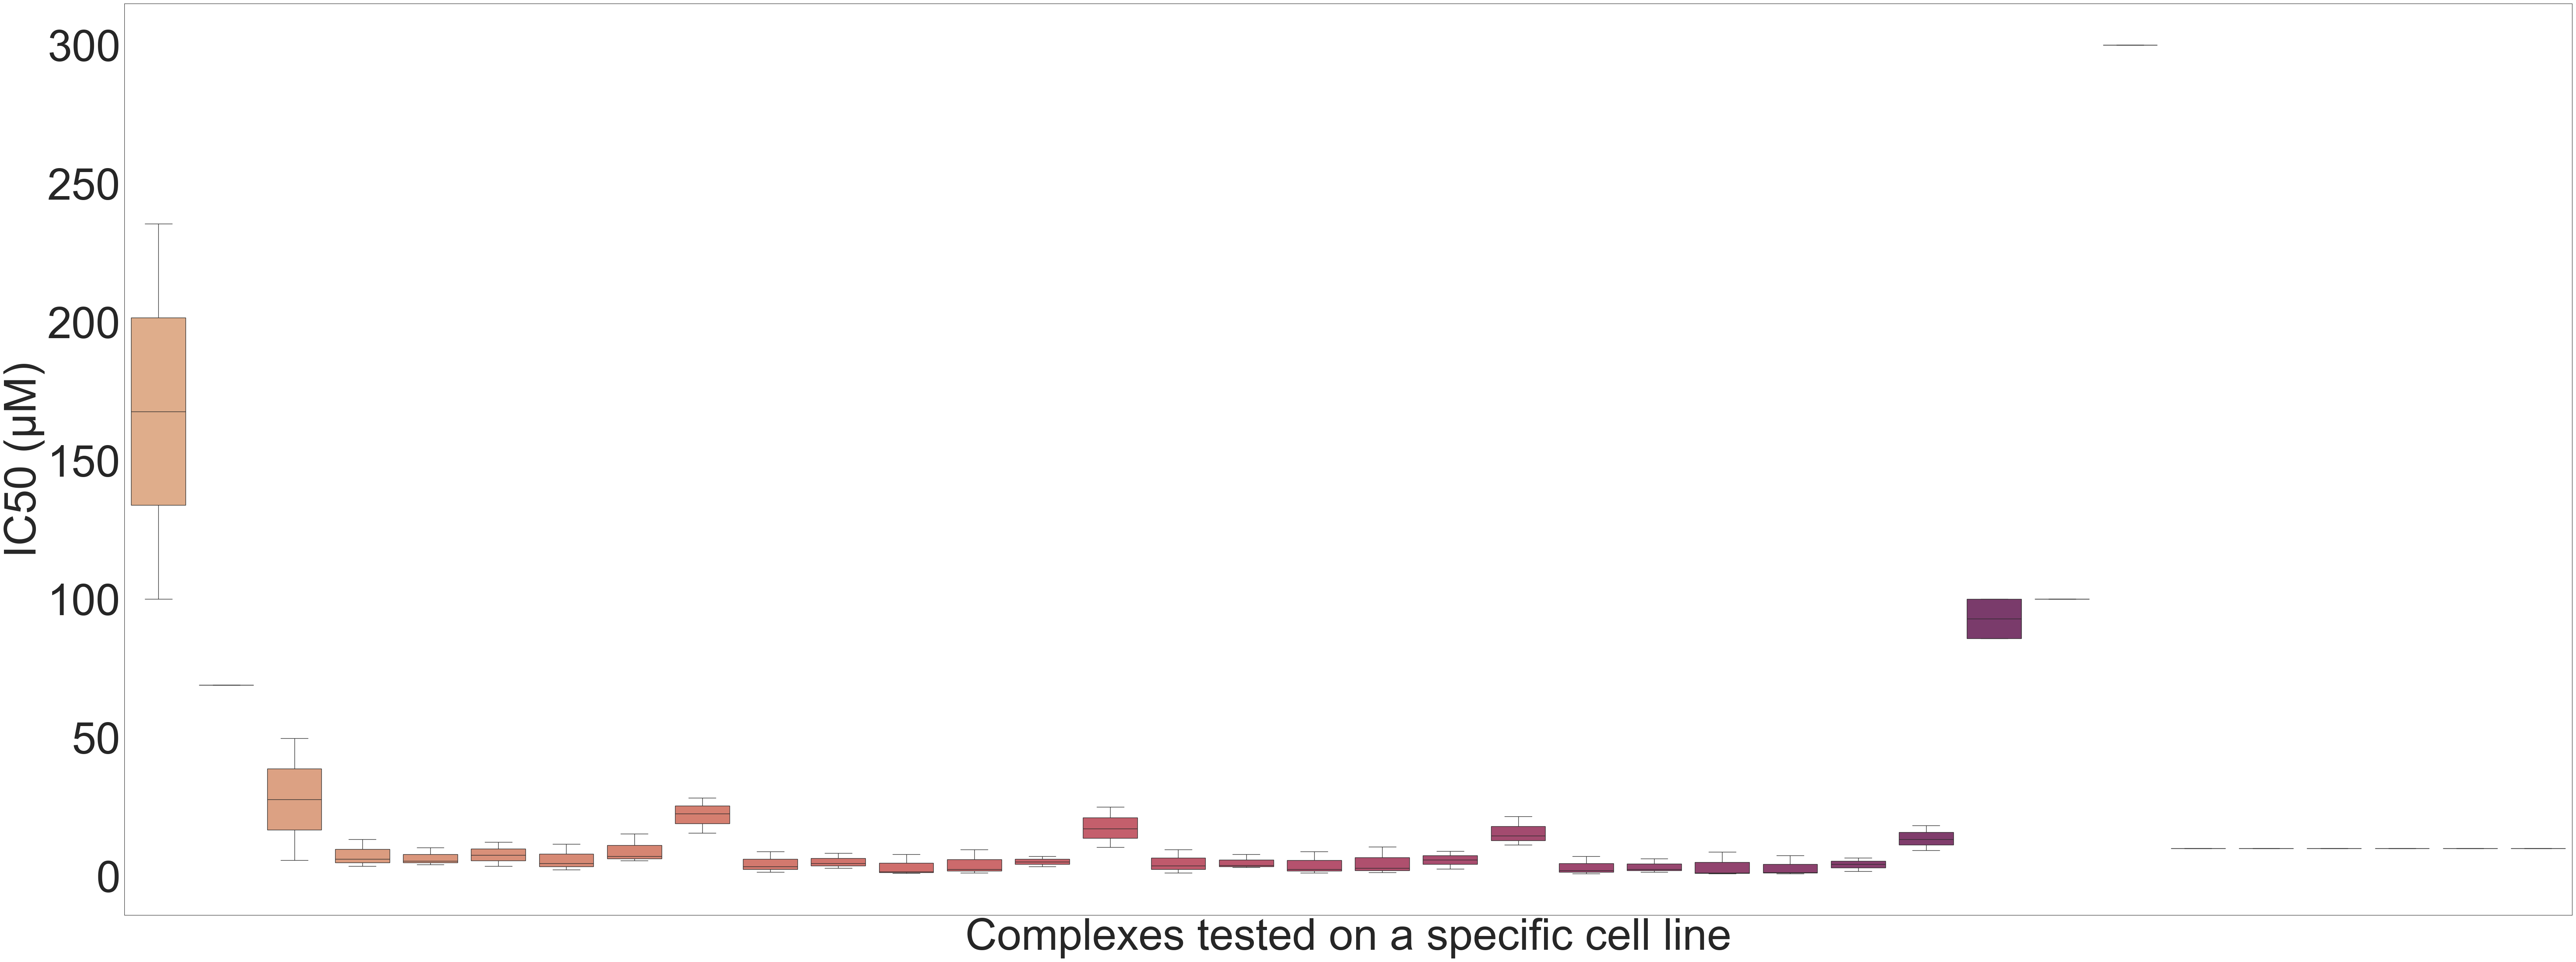

In [47]:
df_incubation_analysis_c = df_incubation_analysis[df_incubation_analysis['Localisation'] == 'nucleus'] # cytoplasma is empty

generate_box_plot("IC50 variation depending on the incubation time for various complexes", df_incubation_analysis_c, 
                  "R+C", "IC50", "Complexes tested on a specific cell line", "IC50 (μM)")

C:\Users\bparm\AppData\Local\Temp\ipykernel_23544\1774195937.py:3: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.boxplot(x=x_column, y=y_column, data=df, palette='flare')


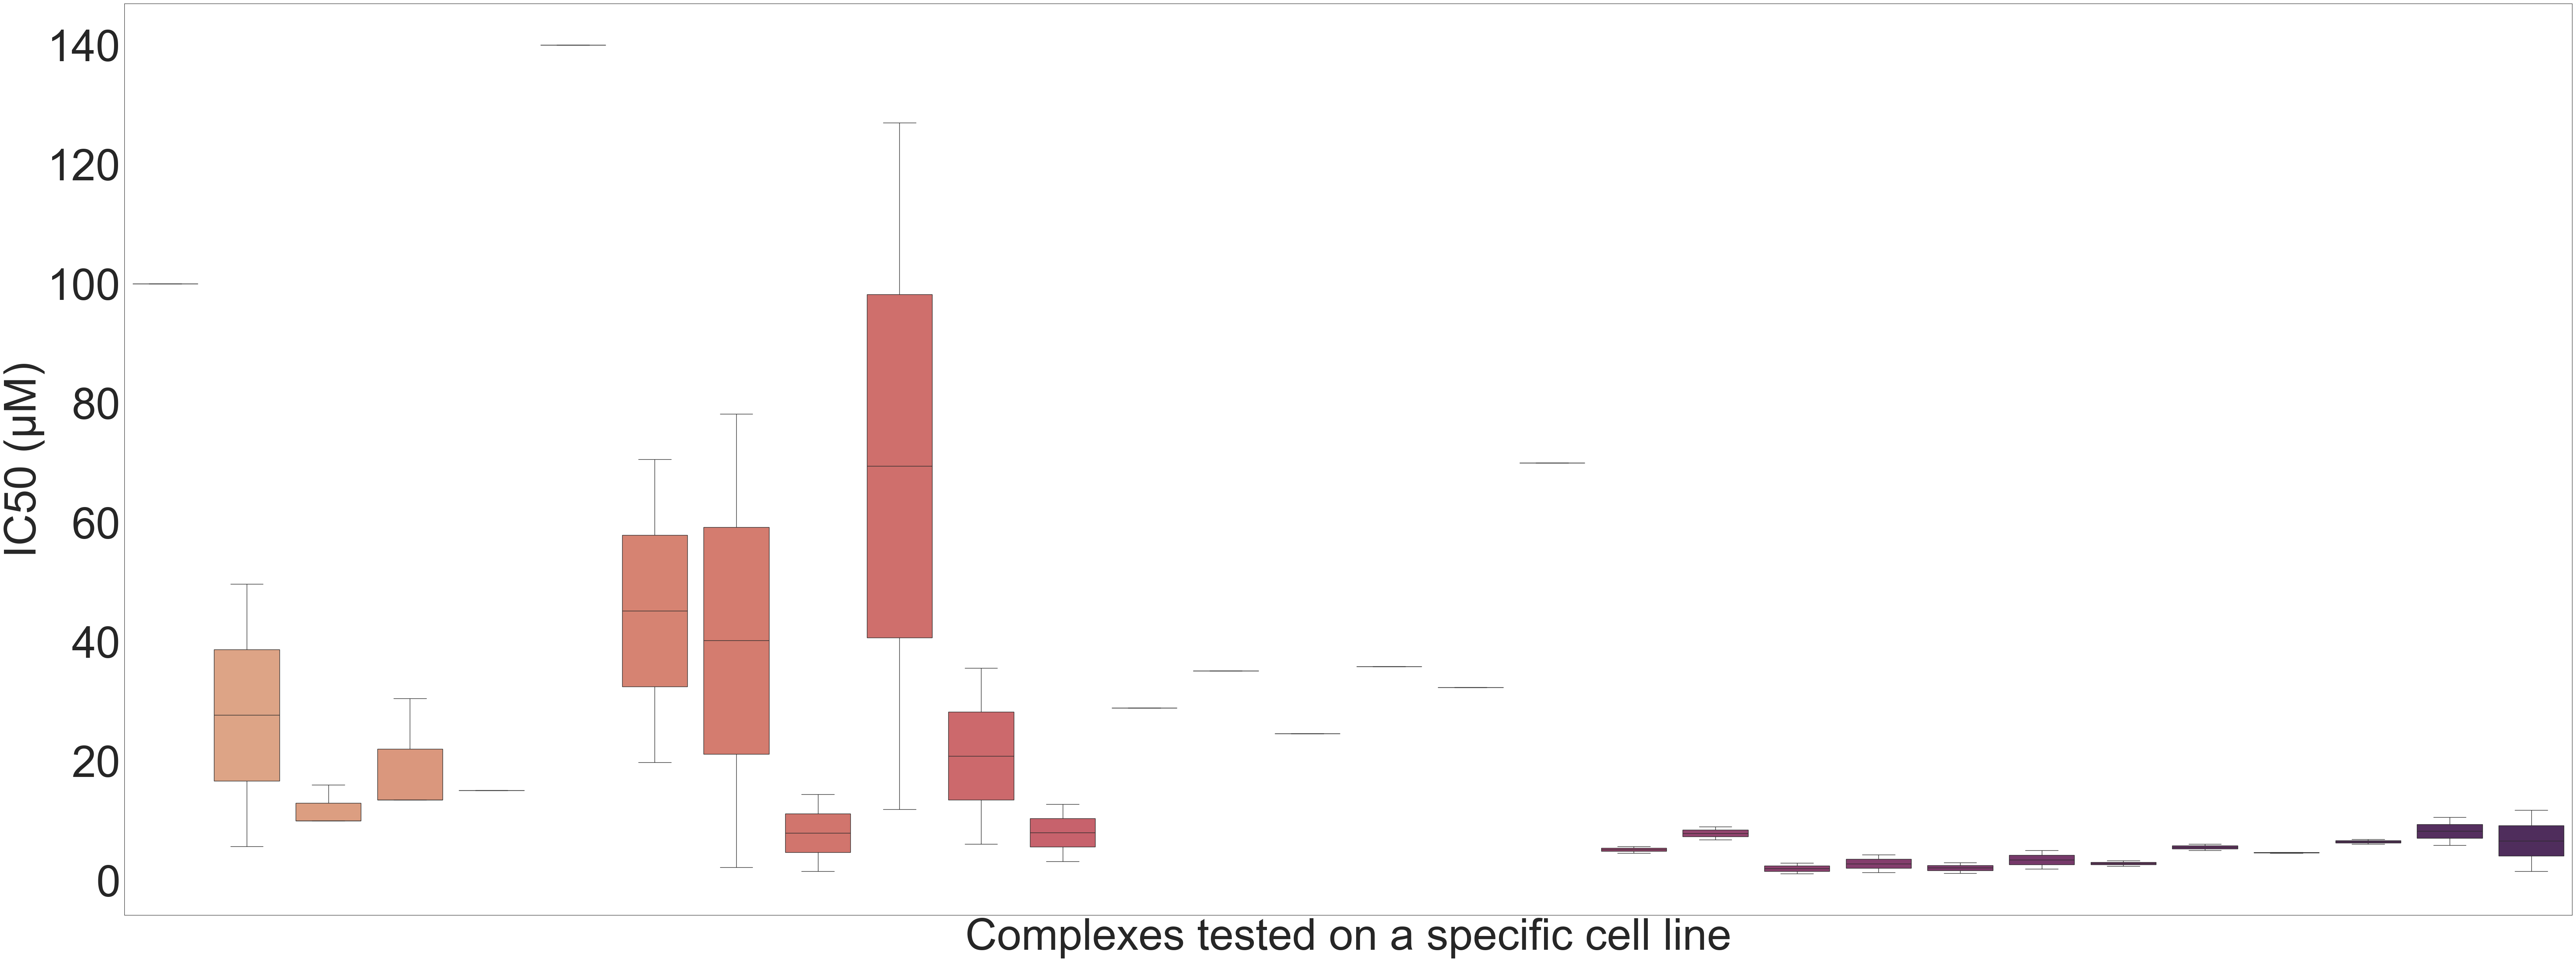

In [48]:
df_incubation_analysis_n = df_incubation_analysis[df_incubation_analysis['Localisation'] == 'mitochondria']

generate_box_plot("IC50 variation depending on the incubation time for various complexes", df_incubation_analysis_n, 
                  "R+C", "IC50", "Complexes tested on a specific cell line", "IC50 (μM)")


=> Complexes tried on a specific cell line are only seldomly evaluated at different incubation times, but when they are, we get significant variation of the IC50 values!    

Finally, we consider the effect of the localization.

**We expect the localisation to have no impact on the IC50** : if a compound has been found in various locations in the cell, it still undergoes only one IC50 test on each cell line.

**First, we only keep the compounds that have been found in different localisations :** 

In [49]:
df_localisation_analysis = df_metal_complexes.copy()
# To have a hashable object that can be runed by "groupby" function, we have to modify the 'complex_representation' column
df_localisation_analysis['Fingerprint'] = df_localisation_analysis['Fingerprint'].apply(lambda x: ' '.join(str(x)))

# filter out the NaN values for the localisation
df_localisation_analysis = df_localisation_analysis.dropna(subset=['Localisation'])

# We only keep the rows where the 'complex_representation' + Cells + IncubationTime' tuple has more than one unique value in the 'Localisation' column.
df_localisation_analysis = df_localisation_analysis.groupby(['Fingerprint', 'Cells', 'IncubationTime']).filter(lambda x: x['Localisation'].nunique() > 1)

In [50]:
number_of_unique_values = df_localisation_analysis['Fingerprint'].nunique()
print("Unique values in 'Fingerprint' column:", number_of_unique_values)

Unique values in 'Fingerprint' column: 78


C:\Users\bparm\AppData\Local\Temp\ipykernel_23544\1774195937.py:3: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.boxplot(x=x_column, y=y_column, data=df, palette='flare')


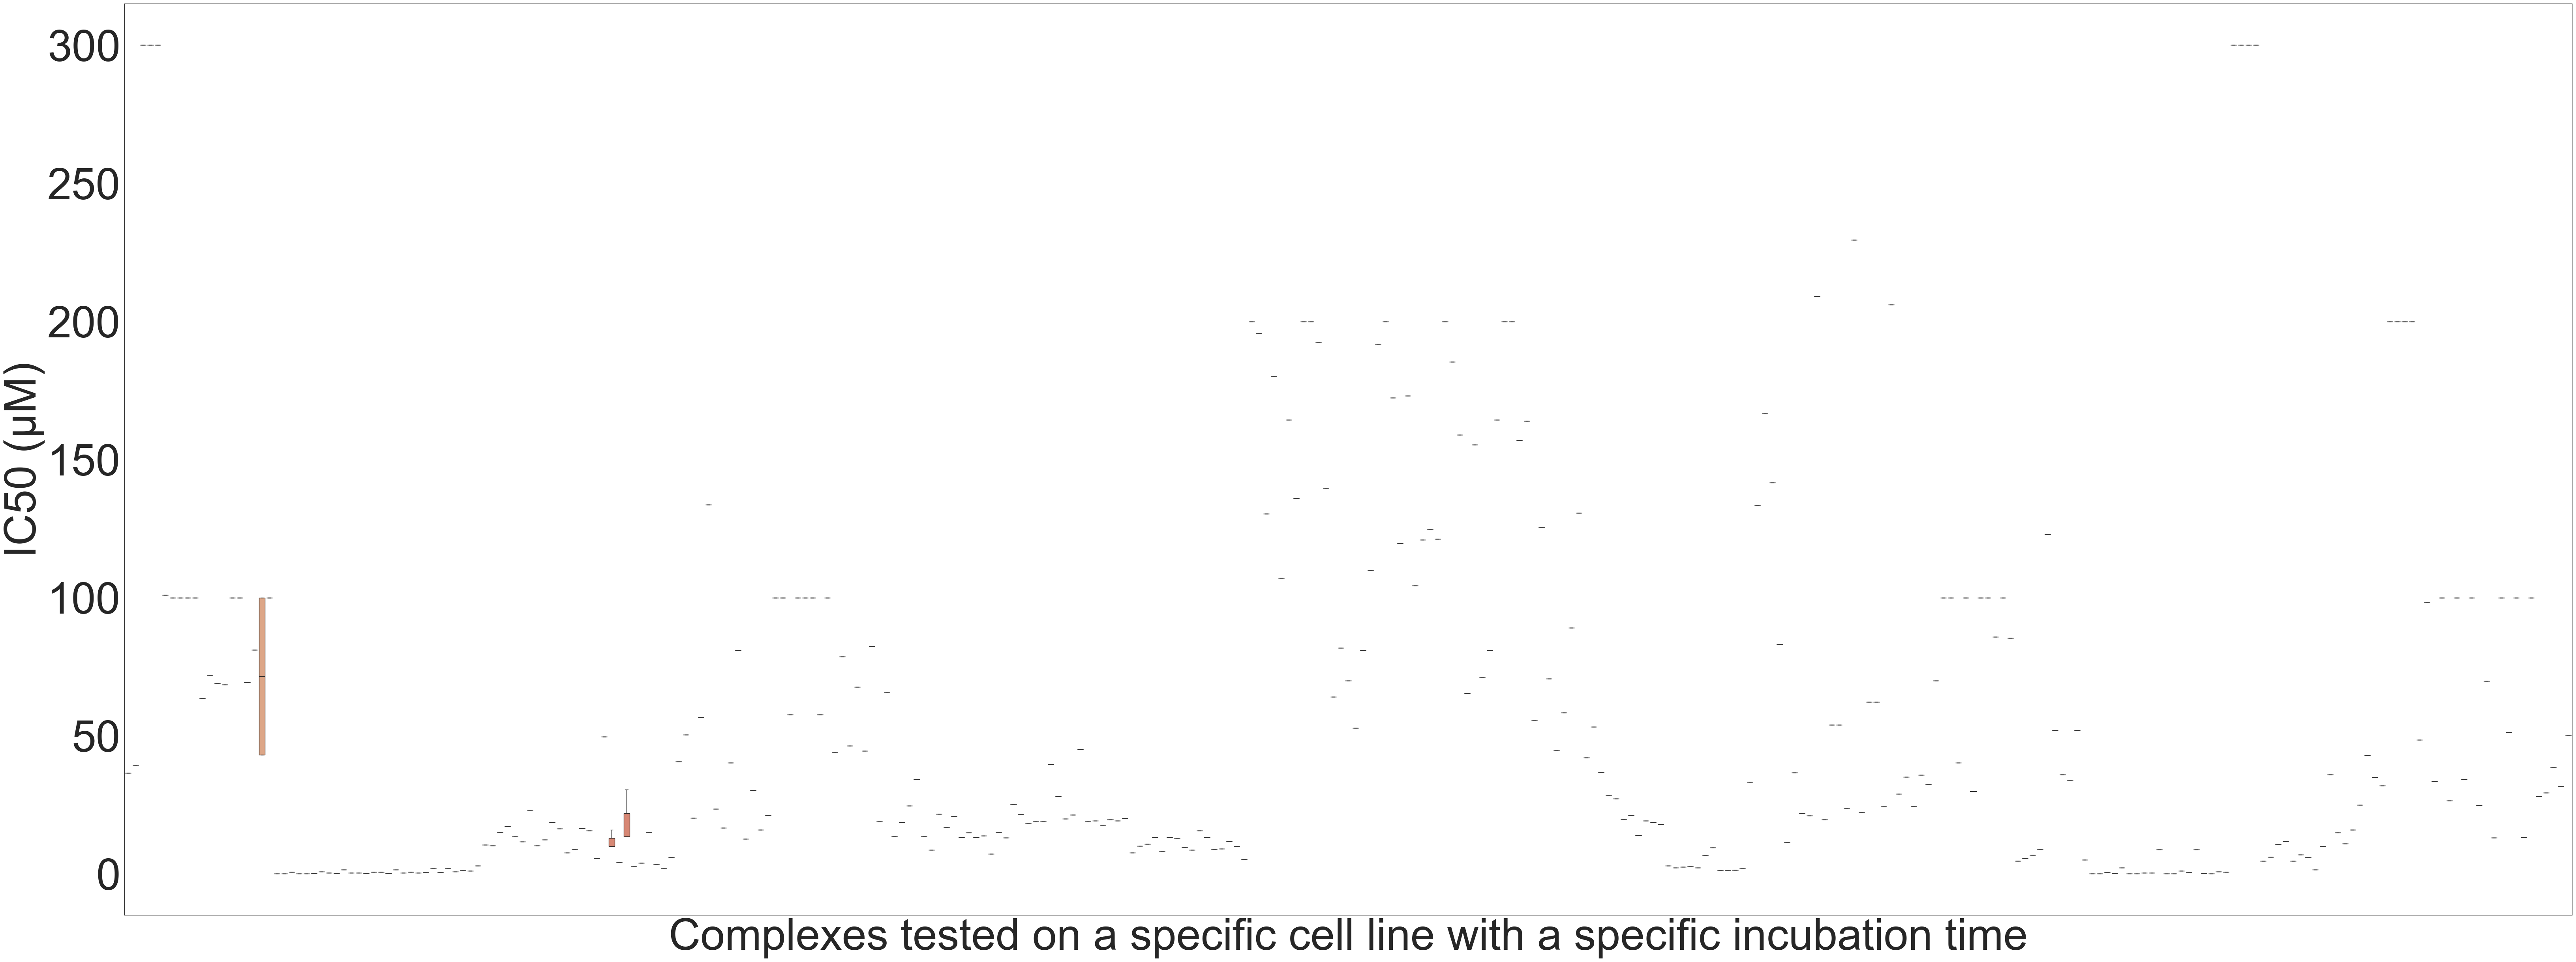

In [51]:
# Combine columns 'complex_representation' and 'Cells', so that we have a compound tested on a specific cell line
df_localisation_analysis['R+C+I'] = df_localisation_analysis.apply(
    lambda x: ' '.join(str(x['Fingerprint'])) + x['Cells'] + str(x['IncubationTime']), axis=1)

generate_box_plot("IC50 variation depending on the localization", df_localisation_analysis, 
                  "R+C+I", "IC50", "Complexes tested on a specific cell line with a specific incubation time", "IC50 (μM)")

=> The localization indeed appears to have no effect on the IC50 values

### Data Analysis on the 'HeLa 48' Dataset

This part is similar to 'Different Compounds and Ligands Available'.

In [90]:
df_hela_48 = df_metal_complexes.copy()
df_hela_48 = df_hela_48[df_hela_48['IncubationTime'] == 48]
df_hela_48 = df_hela_48[df_hela_48['Cells'] == 'HeLa']


all_ligands = pd.concat([df_hela_48['L1'], df_hela_48['L2'], df_hela_48['L3']])
ligands = pd.DataFrame(all_ligands.unique(), columns=['SMILES'])
ligands.dropna(subset=['SMILES'], inplace=True)
print(f'The number of unique ligands currently in the HeLa 48 dataset: {len(ligands)}')

The number of unique ligands currently in the HeLa 48 dataset: 120


In [91]:
ligands['occurences'] = 0 #we create a numerical column to count the occurences of each ligand.
ligand_occurence_dict = dict(zip(ligands['SMILES'], ligands['occurences']))

for l1 in df_hela_48['L1']:
    ligand_occurence_dict[l1] += 1
for l2 in df_hela_48['L2']:
    ligand_occurence_dict[l2] += 1
for l3 in df_hela_48['L3']:
    if pd.notna(l3): 
        ligand_occurence_dict[l3] += 1

In [92]:
sorted_ligands_dict = sorted(ligand_occurence_dict.items(), key=lambda x: x[1], reverse=True)

mol_grid_dict = dict()
mol_grid_dict['SMILES'] = [x[0] for x in sorted_ligands_dict]
mol_grid_dict['occurences'] = [x[1] for x in sorted_ligands_dict]
mol_grid_dict['molecules'] = [Chem.MolFromSmiles(x[0]) for x in sorted_ligands_dict]

mols2grid.display(mol_grid_dict, subset =["img","occurences", "SMILES"], substruct_highlight=True)

MolGridWidget()

# IC50 vs pIC50

In [14]:
metals = df_metal_complexes

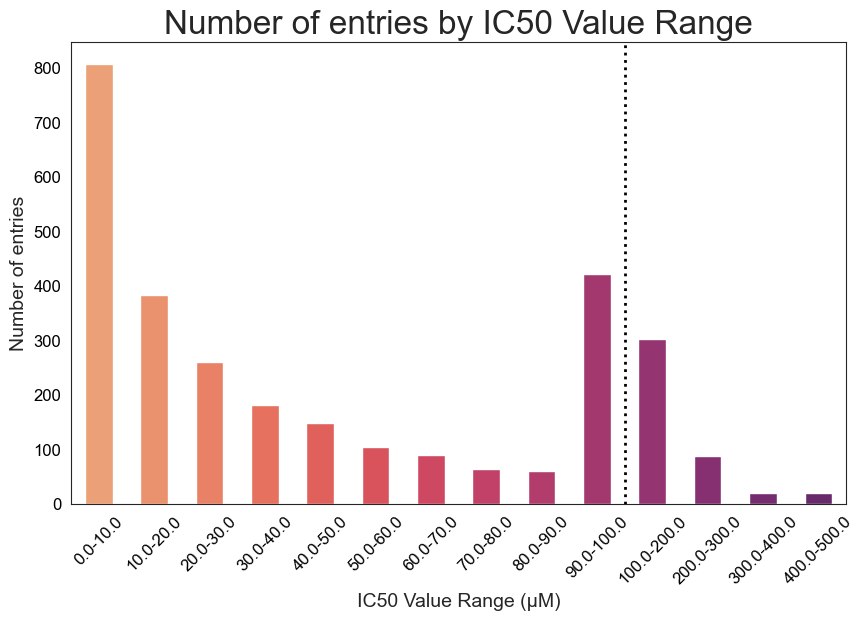

In [71]:
n = 10  # Number of subsets for the range [0, 100]
p = 4  # Number of subsets for the range [100, 500]

bin_edges_1 = np.linspace(0, 100, n+1)
bin_edges_2 = np.linspace(100, 500, p+1)
bin_edges = np.concatenate((bin_edges_1, bin_edges_2[1:]))

# Create bins and labels
bins = list(bin_edges)
labels = [f'{bins[i]}-{bins[i+1]}' for i in range(len(bins)-1)]

# Apply binning and count the number of compounds in each bin
plot_metals = df_metal_complexes.copy()
plot_metals['Y_bins'] = pd.cut(plot_metals['IC50'], bins=bin_edges, labels=labels, include_lowest=True)
counts = plot_metals['Y_bins'].value_counts().sort_index()

break_label = '90.0-100.0'
split_idx = counts.index.tolist().index(break_label) + 1

# Plot the bar plot
generate_bar_plot(counts, 'Number of entries by IC50 Value Range', 'IC50 Value Range (μM)', 
                  'Number of entries', len(bin_edges), break_axis=True)

In [20]:
metals['pIC50'] = metals['IC50'].apply(lambda x: -np.log10(x*10**(-6)))

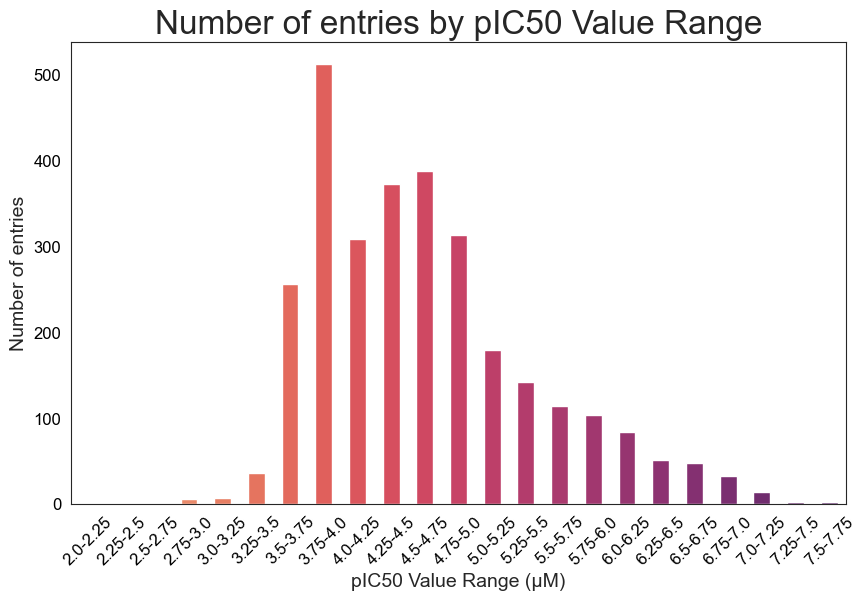

In [65]:
bin_edges  = np.arange(2, 8, 0.25)

# Create bins and labels
bins = list(bin_edges)
labels = [f'{bins[i]}-{bins[i+1]}' for i in range(len(bins)-1)]

# Apply binning and count the number of compounds in each bin
plot_metals = metals.copy()
plot_metals['Y_bins'] = pd.cut(plot_metals['pIC50'], bins=bin_edges, labels=labels, include_lowest=True)
counts = plot_metals['Y_bins'].value_counts().sort_index()

# Plot the bar plot
generate_bar_plot(counts, 'Number of entries by pIC50 Value Range', 'pIC50 Value Range (μM)', 
                  'Number of entries', len(bin_edges))